# PERBANDINGAN METODE KLASTER K-MEDOIDS DAN K-MEANS TERHADAP HASIL PERAMALAN KEMISKINAN DI INDONESIA MENGGUNAKAN BPNN
### by Riansyah Fazar Ramadhan

## 1. Import Dependencies

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import tensorflow as tf
import matplotlib.pyplot as plt

## 2. Data Preprocessing

In [2]:
data1 = pd.read_excel("E:/AKTUARIA FINAL SEASON/DATA/fpdata.xlsx", sheet_name="y", index_col=0)
data2 = pd.read_excel("E:/AKTUARIA FINAL SEASON/DATA/fpdata.xlsx", sheet_name="x1", index_col=0)
data3 = pd.read_excel("E:/AKTUARIA FINAL SEASON/DATA/fpdata.xlsx", sheet_name="x2", index_col=0)
data4 = pd.read_excel("E:/AKTUARIA FINAL SEASON/DATA/fpdata.xlsx", sheet_name="x3", index_col=0)

y = np.array(data1)
x1 = np.array(data2)
x2 = np.array(data3)
x3 = np.array(data4)

data1_flat = data1.values.flatten()
data2_flat = data2.values.flatten()
data3_flat = data3.values.flatten()
data4_flat = data4.values.flatten()

In [3]:
data = pd.DataFrame({
    'y': data1_flat,
    'x1': data2_flat,
    'x2': data3_flat,
    'x3': data4_flat
})
data

,y,x1,x2,x3
0,17.080000,-1.970,7.73,0.334000
1,10.530000,4.990,6.39,0.336000
2,7.310000,5.625,5.99,0.342000
3,8.420000,-1.035,6.72,0.364000
4,8.860000,4.555,2.73,0.361000
...,...,...,...,...
607,11.636808,5.675,2.27,0.361471
608,16.256020,4.650,6.31,0.282647
609,6.512500,21.560,4.31,0.311061
610,20.156875,4.790,5.38,0.370000


## 3. Descriptive Stats

In [4]:
desc_stat = data.describe()
desc_stat

,y,x1,x2,x3
count,612.000000,612.000000,612.000000,612.000000
mean,10.771365,4.553186,5.030539,0.352567
std,5.609865,4.048237,1.788318,0.040239
min,3.420000,-21.300000,0.880000,0.236000
25%,6.377500,3.530000,3.697500,0.324000
50%,9.035000,5.030000,4.655000,0.351000
75%,13.805000,5.765000,6.162500,0.381000
max,28.540000,25.860000,10.950000,0.459000


In [5]:
#writer = pd.ExcelWriter('pooled_data.xlsx', engine='xlsxwriter')
#with pd.ExcelWriter('pooled_data.xlsx', engine='xlsxwriter') as writer:
    #data.to_excel(writer, sheet_name='data', index=False)
    #desc_stat.to_excel(writer, sheet_name='desc_stat')

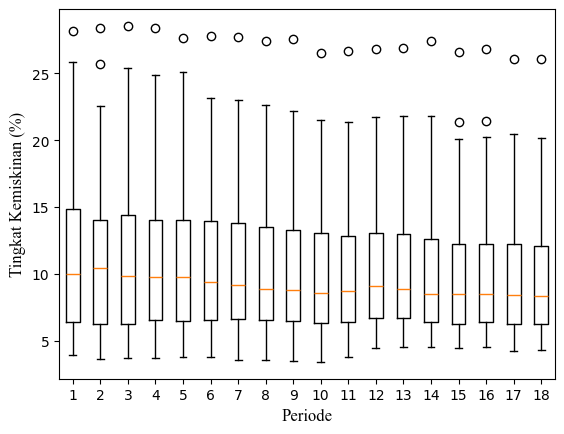

In [6]:
# Create a boxplot
font_prop = {'family': 'Times New Roman', 'color': 'black', 'weight': 'normal', 'size': 12}
plt.boxplot(data1.T)
plt.xlabel('Periode', fontdict=font_prop)
plt.ylabel('Tingkat Kemiskinan (%)', fontdict=font_prop)
plt.show()

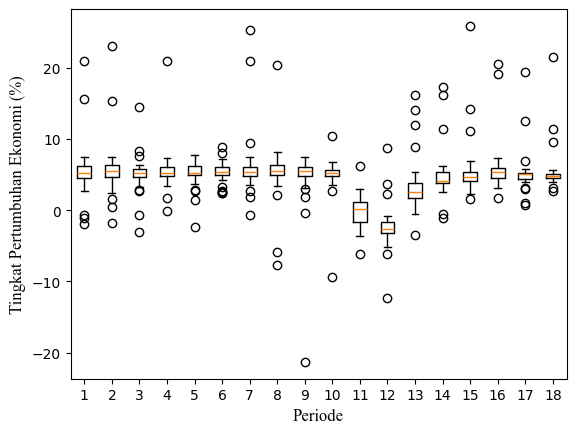

In [7]:
# Create a boxplot
font_prop = {'family': 'Times New Roman', 'color': 'black', 'weight': 'normal', 'size': 12}
plt.boxplot(data2.T)
plt.xlabel('Periode', fontdict=font_prop)
plt.ylabel('Tingkat Pertumbuhan Ekonomi (%)', fontdict=font_prop)
plt.show()

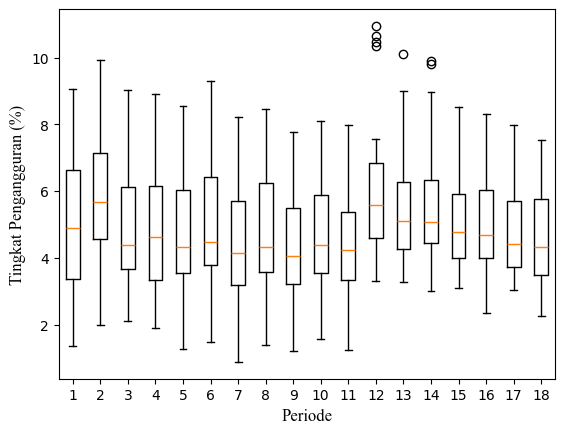

In [8]:
# Create a boxplot
font_prop = {'family': 'Times New Roman', 'color': 'black', 'weight': 'normal', 'size': 12}
plt.boxplot(data3.T)
plt.xlabel('Periode', fontdict=font_prop)
plt.ylabel('Tingkat Pengangguran (%)', fontdict=font_prop)
plt.show()

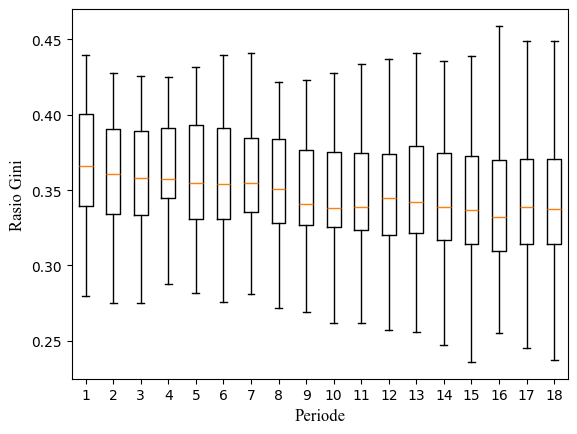

In [9]:
# Create a boxplot
font_prop = {'family': 'Times New Roman', 'color': 'black', 'weight': 'normal', 'size': 12}
plt.boxplot(data4.T)
plt.xlabel('Periode', fontdict=font_prop)
plt.ylabel('Rasio Gini', fontdict=font_prop)
plt.show()

## 4. Terasvirta Linearity Test
#### Done in R language, check at terasvirtatest.R

## 6. Min-max Normalization

In [4]:
from sklearn.preprocessing import MinMaxScaler

def standardize_data(data):
    scaler = MinMaxScaler(feature_range=(-1,1))
    data_norm = scaler.fit_transform(data)
    return data_norm, scaler

x1_norm, x1_scaler = standardize_data(data2_flat.reshape(-1,1))
x2_norm, x2_scaler = standardize_data(data3_flat.reshape(-1,1))
x3_norm, x3_scaler = standardize_data(data4_flat.reshape(-1,1))
y_norm, y_scaler = standardize_data(data1_flat.reshape(-1,1))

In [5]:
data_norm = np.column_stack([y_norm, x1_norm, x2_norm, x3_norm])

## 7. Data Splitting

In [6]:
SPLIT_TIME = 476
data_train = data_norm[:SPLIT_TIME]
data_test = data_norm[SPLIT_TIME:]

In [7]:
def prefetch_dataset(features, labels, batch_size):
    ds = tf.data.Dataset.from_tensor_slices((features, labels))
    return ds.batch(batch_size).prefetch(1)

In [10]:
train_features = data_train[:, 1:]  # Features
train_labels = data_train[:, 0]     # Labels
test_features = data_test[:, 1:]
test_labels = data_test[:, 0]

train_set = prefetch_dataset(train_features, train_labels, 1)
test_set = prefetch_dataset(test_features, test_labels, 1)

## 8. Neural Network Architecture

In [57]:
def modelling(train_dataset, test_dataset, epoch, loss_function, optimizer, activation, hidden_node, replication):
        model = tf.keras.models.Sequential([
                tf.keras.layers.Input(shape=(train_features.shape[1],)),
                tf.keras.layers.Dense(hidden_node, activation=activation),
                tf.keras.layers.Dense(1)
                ])
        model.compile(loss=loss_function, optimizer=optimizer, metrics=[mape])
        #early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        history = model.fit(train_dataset, epochs=epoch, validation_data=test_dataset) #callbacks=[early_stopping])
        if __name__ == '__main__':
                model.save(f"model_y_{replication}_{hidden_node}.h5")
        train_loss = history.history['loss'][-1]
        test_loss = history.history['val_loss'][-1]
        train_epoch = len(history.epoch)
        weights = model.get_weights()
        return train_loss, test_loss, train_epoch, weights[0], weights[1], weights[2], weights[3]

In [ ]:
model_sum = pd.DataFrame(columns=['replication', 'hidden_node', 'train_mse', 'test_mse', 'epoch', 'hl_weights', 'hl_bias', 'ol_weights', 'ol_bias'])
for rep in range(1, 6):
    iterasi = (rep - 1) * 20 + 1
    for n in range(1, 21):
        a,b,c,d,e,f,g = modelling(train_dataset=train_set, 
                                    test_dataset=test_set,
                                    epoch=50, 
                                    loss_function='mse',
                                    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
                                    activation='relu',
                                    hidden_node=n,
                                    replication=rep)
        idx = iterasi + n
        model_sum.loc[idx] = [rep,n,a,b,c,d,e,f,g]
    model_sum.to_excel(f'main_model_summary.xlsx')               

In [33]:
def mape(y_true, y_pred):
    """
    Compute Mean Absolute Percentage Error (MAPE).

    Args:
    y_true (tensor): Actual values.
    y_pred (tensor): Predicted values.

    Returns:
    tensor: MAPE value.
    """
    # Ensure the values are floating point tensors to avoid division issues
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    # Calculate the absolute percentage error
    error = tf.abs((y_true - y_pred) / tf.clip_by_value(tf.abs(y_true), 1e-7, tf.reduce_max(tf.abs(y_true))))
    
    # Calculate the mean of the absolute percentage error
    mape_value = tf.reduce_mean(error)
    return mape_value

In [58]:
modelling(train_dataset=train_set, 
                                    test_dataset=test_set,
                                    epoch=500, 
                                    loss_function='mse',
                                    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
                                    activation='relu',
                                    hidden_node=18,
                                    replication=2)

Epoch 1/500
238/238 [==============================] - 1s 2ms/step - loss: 0.2292 - mape: 2.2572 - val_loss: 0.1579 - val_mape: 6.5071
Epoch 2/500
238/238 [==============================] - 0s 2ms/step - loss: 0.1852 - mape: 2.9198 - val_loss: 0.1435 - val_mape: 7.3666
Epoch 3/500
238/238 [==============================] - 0s 2ms/step - loss: 0.1767 - mape: 2.9836 - val_loss: 0.1401 - val_mape: 7.4468
Epoch 4/500
238/238 [==============================] - 0s 2ms/step - loss: 0.1731 - mape: 2.9453 - val_loss: 0.1385 - val_mape: 7.3563
Epoch 5/500
238/238 [==============================] - 0s 2ms/step - loss: 0.1707 - mape: 2.9061 - val_loss: 0.1372 - val_mape: 7.2428
Epoch 6/500
238/238 [==============================] - 0s 2ms/step - loss: 0.1688 - mape: 2.8656 - val_loss: 0.1370 - val_mape: 7.1454
Epoch 7/500
238/238 [==============================] - 0s 2ms/step - loss: 0.1671 - mape: 2.8246 - val_loss: 0.1371 - val_mape: 7.0463
Epoch 8/500
238/238 [==============================] - 

c:\Users\rians\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


(0.13846123218536377,
 0.1358511596918106,
 500,
 array([[-6.5946855e-02,  2.0910275e-01, -3.7902886e-01, -7.8214926e-01,
         -4.6865690e-01, -1.1614608e-01,  3.5834390e-01,  2.4060291e-01,
          1.3244626e-01, -1.3409101e+00,  4.2020220e-01, -1.9293181e+00,
         -2.4796698e+00, -1.6987736e+00, -3.0809476e+00, -1.2575951e+00,
          7.9479933e-02, -1.0127919e+00],
        [ 9.8890823e-01, -2.1354944e-01,  3.4542158e-02,  3.6266759e-01,
          1.3413812e-01, -5.2611256e-01,  4.3953601e-01, -3.1314954e-01,
         -6.3440078e-01, -4.1861329e-02, -1.3917502e+00,  2.9711523e-03,
          1.6960990e+00,  5.4336524e-01, -1.8021966e+00,  1.7639560e-01,
         -1.1458994e+00, -5.3156912e-01],
        [ 1.4286517e-01, -3.1241247e-01,  8.3634084e-01,  5.2588850e-01,
         -4.6884024e-01,  8.9159027e-02, -2.8626084e-01, -2.7003431e-01,
          2.4108963e-02,  7.3524392e-01,  1.4578978e+00,  6.6253942e-01,
          1.4782765e+00,  8.3111644e-01, -1.8475999e+00,  9.1900

In [11]:
# Load the input data from the Excel file
input_data_path = "E:\\GitHub\\sherlock-final-project\\x_prediction_3.xlsx"
input_data = pd.read_excel(input_data_path)

# Extract the relevant columns (assuming the columns are named 'x1', 'x2', 'x3')
x1_future = input_data['x1'].values
x2_future = input_data['x2'].values
x3_future = input_data['x3'].values

x1_future = x1_scaler.transform(x1_future.reshape(-1,1))
x2_future = x2_scaler.transform(x2_future.reshape(-1,1))
x3_future = x3_scaler.transform(x3_future.reshape(-1,1))

# Combine x1, x2, x3 into a single array
combined_input = np.column_stack([x1_future, x2_future, x3_future])

1/1 [==============================] - 0s 23ms/step
[ 8.262716   8.741388   7.307633  10.16782   10.248547  10.420256
 10.713356   8.962166   6.9672184  8.39155   11.026958   9.79043
 10.646097  12.745676  10.668135   8.72422   11.614157  11.615265
 10.126957   8.362679   9.349016   9.44883    8.824074   8.117718
  9.093941  10.280626  10.651522  11.849768  12.87236   11.512405
  7.1361713 10.351093  10.348549  12.581516   8.254976   8.583645
  7.4859385 10.172255   9.97999   10.066212  10.717943   8.50329
  6.9734807  8.45218   10.958551   9.878134  10.943045  12.608356
 10.6498375  8.940078  11.036018  11.443352   9.802437   7.9932284
  8.744864   9.253958   8.502089   7.6609387  8.540089   9.720926
 10.027351  11.353029  12.347504  10.467403   6.9572525  9.460579
 10.094793  11.847666   7.9747167  8.060295   7.5585866  9.747396
  9.494919   9.4592705 10.430716   7.8628445  6.8460827  8.472496
 10.814596  10.062878  11.112366  12.45643   10.5890465  9.164175
 10.47884   11.393944   9

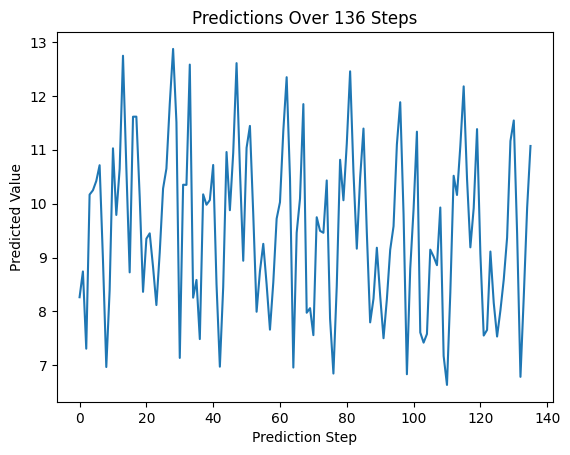

In [48]:
# Number of future data points to predict
num_predictions = 136

# Placeholder for the predictions
predictions = []

# Make sure your model is loaded correctly
# If the model is saved as 'model_x.h5', you can load it like this:
model = tf.keras.models.load_model('y/model_y_2_18.h5')

for i in range(num_predictions):
    # Predict the next data point
    next_pred = model.predict(combined_input[i].reshape(1, -1))
    
    # Append the prediction to the predictions list
    predictions.append(next_pred.squeeze())

# Convert the list of predictions to a NumPy array
y_predictions = np.array(predictions)

print(y_predictions)
plt.plot(y_predictions)
plt.xlabel('Prediction Step')
plt.ylabel('Predicted Value')
plt.title('Predictions Over 136 Steps')
plt.show()

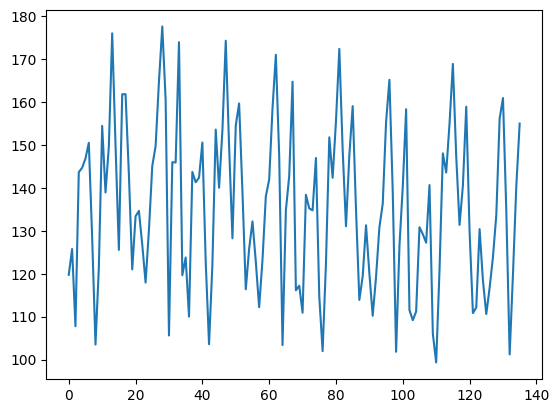

In [49]:
y_predictions = y_predictions.reshape(-1,1)
y_pred = y_scaler.inverse_transform(y_predictions).flatten()
plt.plot(y_pred)

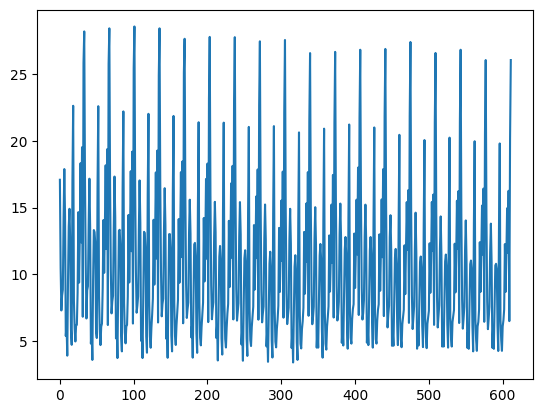

In [ ]:
plt.plot(data1_flat)

In [ ]:
model_pred = pd.DataFrame(y_pred, columns=['y'])
model_pred.to_excel('y_prediction.xlsx')

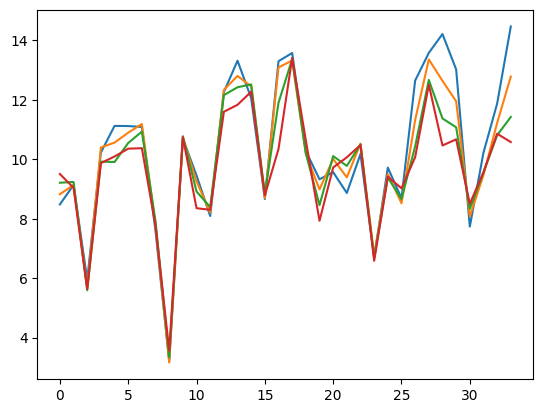

In [38]:
# Reshape the data
reshaped_data = y_pred.reshape((34, 4), order='F')  # 'F' means column-major order

plt.plot(reshaped_data)

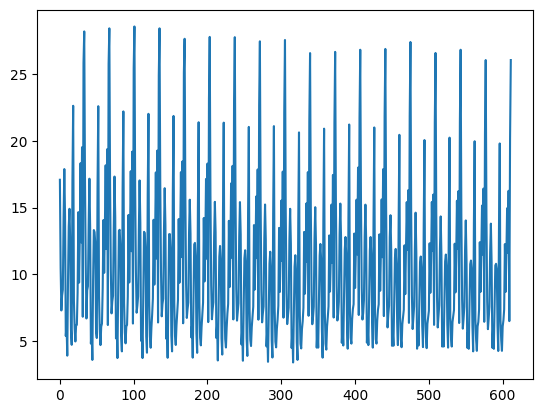

In [ ]:
plt.plot(y.reshape(-1,1))

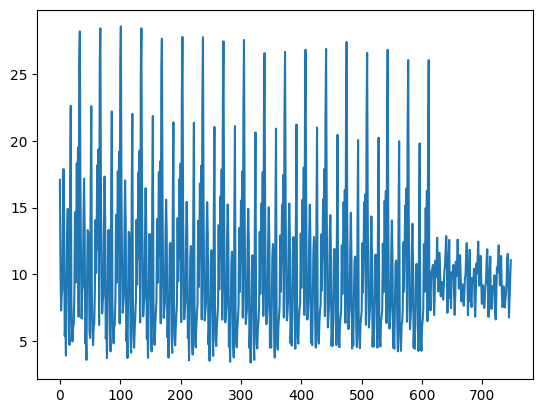

In [52]:
reshaped_previous_data = y.T

# Combine reshaped data and reshaped previous data
combined_data = np.concatenate((data1_flat, y_predictions.flatten()))

plt.plot(combined_data.reshape(-1,1))